## library

In [43]:
import keras
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar100
from keras import layers
from keras.models import Sequential
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

## reading data

In [49]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

## preprocessing

In [50]:
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

## data augmentation

In [57]:
img_aug = Sequential([
    layers.Resizing(64, 64),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

## MobileNet

In [55]:
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# 86 layers

/tmp/ipython-input-125473225.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(64, 64, 3))


## Fine tuning

In [53]:
base_model.trainable = True
for layer in base_model.layers[:65]:
    layer.trainable = False

## model architecture

In [54]:
model = Sequential([
    keras.Input(shape=(32, 32, 3)),
    img_aug,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(100, activation="softmax"),
])

## optimizer and loss

In [58]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## learning rate decay

In [59]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

## checkpoint

In [60]:
checkpoint = ModelCheckpoint("cifar100_bestmodel.weights.h5", monitor="val_loss", verbose=0,
                             save_best_only=True, mode="auto", save_weights_only=True)

## training

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.2, callbacks=[checkpoint, lr_scheduler])

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.0210 - loss: 4.8969 - val_accuracy: 0.0473 - val_loss: 4.6601 - learning_rate: 0.0010
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.0419 - loss: 4.4231 - val_accuracy: 0.1024 - val_loss: 4.2623 - learning_rate: 0.0010
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.0521 - loss: 4.3075 - val_accuracy: 0.1543 - val_loss: 3.5088 - learning_rate: 0.0010
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.0654 - loss: 4.2274 - val_accuracy: 0.1750 - val_loss: 3.3535 - learning_rate: 0.0010
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.0744 - loss: 4.1681 - val_accuracy: 0.1663 - val_loss: 3.3508 - learning_rate: 0.0010
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.0768 - loss: 4.1382 - val_accuracy: 0.1899 - val_loss: 3.3104 - learning_rate: 0.0010
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.0

## result

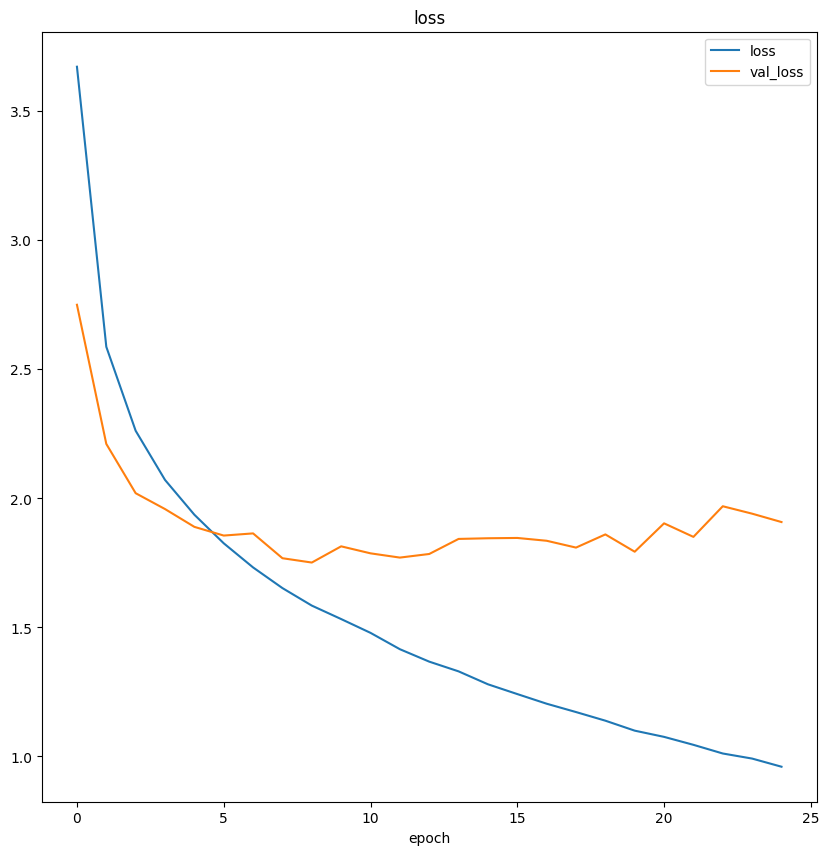

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("loss")
plt.legend(["loss", "val_loss"])
plt.xlabel("epoch")
plt.savefig("result.png")

## testing